In [322]:
#!pip install yfinance --upgrade --no-cache-dir

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()
import chart_studio as cs
from IPython.display import display, HTML
import yfinance as yf
from datetime import datetime, date
import seaborn as sns
%matplotlib inline


/home/matteo/snap/jupyter/common/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [7]:
#estrapolo i dati  per trovare la combinazione di portafoglio adeguata

start_date = '2020-1-1'
end_date = '2020-4-25'
capitale = 100
assets=['PSA', 'TLS', 'FCA']

#Dataframe per valori di chiusura
pf_data = pd.DataFrame()
#Dataframe per i dividendi
date_today = datetime.now()
days = pd.date_range(start_date, end_date , freq='D')
pf_div = pd.DataFrame(index = days)

#Riempio il dataframe pf_data con le diverse stock
for a in assets:
    pf_data[a]= wb.DataReader(a,data_source='yahoo', start = start_date , end= end_date)['Adj Close']

#Riempio il dataframe pf_div con i dividendi delle stock
for a in range(len(assets)):
    
    stock = yf.Ticker(assets[a])
    pf_div[assets[a]]=stock.dividends

pf_div = pf_div.dropna(how='all') #cancella le righe che sono tutte NaN
pf_div.fillna(0, inplace=True) # trasmormo Nan in 0 per fare calcoli

,Mean annual Return [%],Mean annual Dividends [$/stock]
PSA,-35.7,2.0
TLS,13.1,0.0
FCA,-57.8,0.0


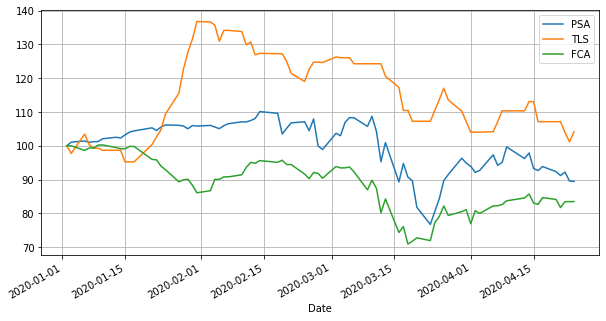

In [8]:
#normalizzo e plotto l'andamento (!!!!!importante normalizzare cosi posso paragonare i risultati)
(pf_data/pf_data.iloc[0]*100).plot(figsize=(10,5), grid= True);
#calcolo ritorno logaritmico gioraliero degli assets mel periodo selezionato
log_returns =np.log(pf_data/pf_data.shift(1))
#percentuale di ritorno annua media di ogni stocks
mean_annual_return = round(log_returns.mean()*250*100,1)
#percentuale di volatilità annua media di ogni stock
#mean_annual_volatility 
#valore dei dividendi medio annua per ogni stock
mean_annual_dividend = round((pd.DataFrame(pf_div.resample('Y').sum())).mean(),2)

#Creo Dataframe per un review veloce
review = pd.DataFrame(index = assets)
review['Mean annual Return [%]'] = mean_annual_return
#review['Mean annual Volatility [%]'] = mean_annual_volatility
review['Mean annual Dividends [$/stock]'] = mean_annual_dividend
review

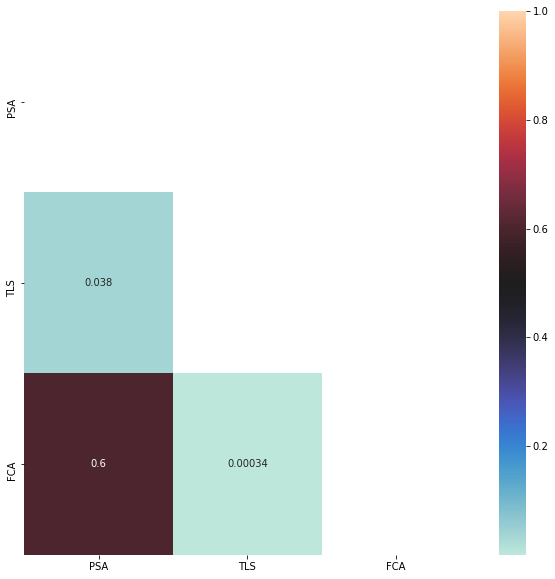

In [9]:
#cambia center per capire meglio la correlazione 
correlation = log_returns.corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(10,10))
sns.heatmap(correlation,center=0.5,annot=True,mask=mask);

In [13]:
#genero tot combinazioni di peso per il tuo portafoglio (nel ciclo for inserisci il n combinazioni) per
#valutare tutte le possibili combinazioni di peso, scegliendo poi quella ottima
num_assets=len(assets)
pfoglio_returns=[]
pfoglio_volatilities=[]
pfoglio_weights=[]
pfoglio_sharpe_ratio = []
pfoglio_dividends = []
risk_free = 0.025 #bot 10 anni US
stock_value = (pf_data.values[0]) #valore della stock allo start_date
                                  #verificare che il primo valore non sia un NaN 

np.random.seed(133)
for x in range (2000):
    
    weights=np.random.random(num_assets)
    weights/=np.sum(weights)
    weights = np.around(weights,4)
    returns = np.around(np.sum(weights* log_returns.mean())*250,4)  
    volatility = np.around(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*250,weights))),4)
    sharpe_ratio = np.around((returns - risk_free)/volatility,2)
    n_stocks = capitale*weights/stock_value
    dividends = np.around(np.sum((pf_div*n_stocks).sum(axis = 0)),2)
       
    pfoglio_weights.append(weights)
    pfoglio_returns.append(returns)
    pfoglio_volatilities.append(volatility)
    pfoglio_sharpe_ratio.append(sharpe_ratio)
    pfoglio_dividends.append(dividends)
    

portfoglios=pd.DataFrame({'Return': pfoglio_returns, 'Volatility': pfoglio_volatilities,
                          'Sharpe Ratio': pfoglio_sharpe_ratio, 'Dividends': pfoglio_dividends})
portfoglios=pd.concat([portfoglios, pd.DataFrame(pfoglio_weights)], axis=1);
columns_name = [ 'Returns', 'Volatility','Sharpe Ratio', 'Dividends'] + ["Weight_" + assets for assets in assets]
portfoglios.columns= columns_name

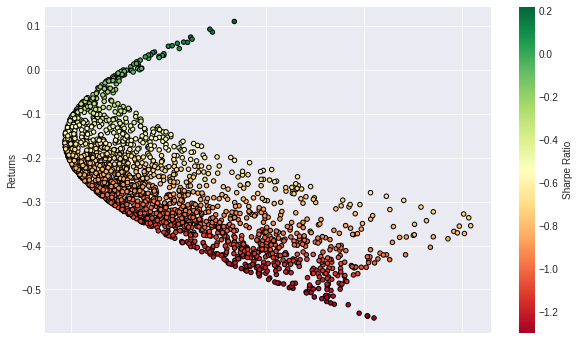

In [14]:
#plottiamo i dati delle combinazioni di portafoglio 
#portfoglios.iplot(x='Volatility', y='Returns', kind='scatter',mode='markers',size=5);
plt.style.use('seaborn-dark')
portfoglios.plot( x='Volatility', y='Returns', kind='scatter',figsize=(10,6),
                  c='Sharpe Ratio', cmap='RdYlGn', edgecolors='black',grid=True);


In [15]:
min_volatility = portfoglios['Volatility'].min()
max_sharpe = portfoglios['Sharpe Ratio'].max()
max_yield = portfoglios['Dividends'].max()
# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = portfoglios.loc[portfoglios['Sharpe Ratio'] == max_sharpe]
min_variance_port = portfoglios.loc[portfoglios['Volatility'] == min_volatility]
dividends_port = portfoglios.loc[portfoglios['Dividends'] == max_yield]

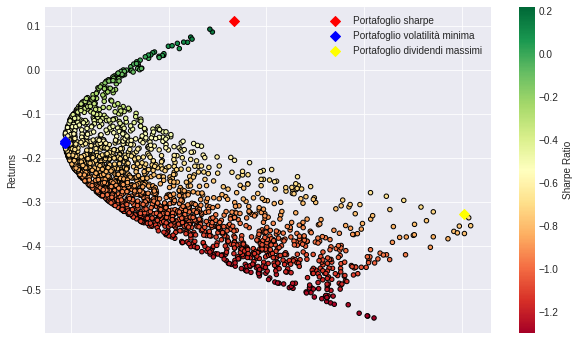

In [16]:
plt.style.use('seaborn-dark')
portfoglios.plot( x='Volatility', y='Returns', kind='scatter',figsize=(10,6),
                  c='Sharpe Ratio', cmap='RdYlGn', edgecolors='black',grid=True);
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], 
            c='red', marker='D', s=50 , label = 'Portafoglio sharpe');
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], 
            c='blue', marker='D', s=50, label = 'Portafoglio volatilità minima');
plt.scatter(x= dividends_port['Volatility'], y= dividends_port['Returns'], 
            c='yellow', marker='D', s=50, label = 'Portafoglio dividendi massimi');
plt.legend();


In [17]:
display(min_variance_port)
display(sharpe_portfolio)


,Returns,Volatility,Sharpe Ratio,Dividends,Weight_PSA,Weight_TLS,Weight_FCA
152,-0.1664,0.297,-0.64,0.13,0.1348,0.5387,0.3265
311,-0.1675,0.297,-0.65,0.11,0.1179,0.5424,0.3397
475,-0.1612,0.297,-0.63,0.13,0.1393,0.5446,0.3161
1660,-0.1672,0.297,-0.65,0.13,0.1364,0.5370,0.3265
1670,-0.1668,0.297,-0.65,0.12,0.1301,0.5395,0.3304


,Returns,Volatility,Sharpe Ratio,Dividends,Weight_PSA,Weight_TLS,Weight_FCA
1175,0.11,0.3836,0.22,0.03,0.0317,0.9608,0.0075


In [18]:
weight_sharpe = sharpe_portfolio.iloc[:, 4:(len(assets)+4)]
weight_minvar = min_variance_port.iloc[:, 4:(len(assets)+4)] # +3 per aggiungere le prime tre colonne
weight_sharpe

,Weight_PSA,Weight_TLS,Weight_FCA
1175,0.0317,0.9608,0.0075


In [19]:

review = pd.DataFrame(index = assets)
review['Weight Sharpe Portfolio [$]'] = np.around(weight_sharpe.values[0]*capitale,1) 
review['Weight Min Variance Portfolio [$]'] = np.around(weight_minvar.values[0]*capitale,1) 
review

,Weight Sharpe Portfolio [$],Weight Min Variance Portfolio [$]
PSA,3.2,13.5
TLS,96.1,53.9
FCA,0.8,32.6


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



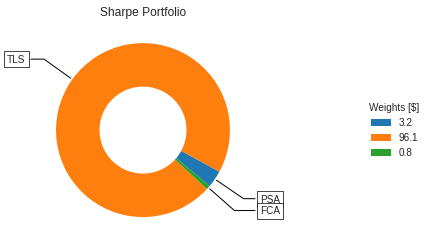

In [20]:
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(weight_sharpe, wedgeprops=dict(width=0.5), startangle=-40)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(assets[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Sharpe Portfolio");

ax.legend(wedges, review.iloc[:,0],
          title="Weights [$]",
          loc="center left",
          bbox_to_anchor=(1.5, 0, 0.5, 1))
plt.show();

In [ ]:
#testiamo i tuoi portafoglio dal 2017 in poi (fingo che ci troviamo nel 2017, costruisco i portafogli con i dati fino al 2017)
#dal 2017 ad oggi lo considero futuro.
#vediamo cosa succede

In [305]:
#estrapolo i dati dal 2017 in poi 

pf_data2 = pd.DataFrame()

for a in assets:
    pf_data2[a]= wb.DataReader(a,data_source='yahoo', start ='2017-1-1')['Adj Close']

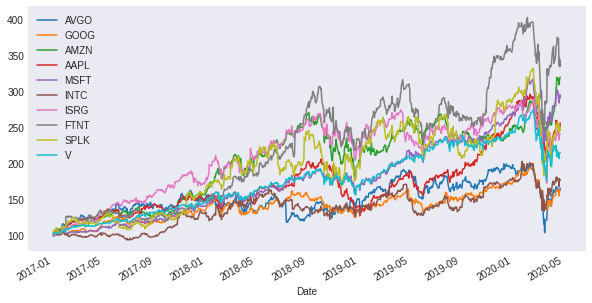

In [306]:
#normalizzo e plotto l'andamento dal 2017 a oggi
(pf_data2/pf_data2.iloc[0]*100).plot(figsize=(10,5));

In [307]:
#adesso inizia il processo di calcolo dei rendimenti e volaitilà del tuo portafoglio e quello fatto per avere volatilità minima
#calcolo ritorno logaritmico gioraliero degli assets
log_returns2 =np.log(pf_data2/pf_data2.shift(1))

In [308]:
#percentuale di ritorno annua media di ogni stocks
log_returns2.mean()*250*100

AVGO    15.058821
GOOG    14.631649
AMZN    34.931452
AAPL    28.203034
MSFT    32.524556
INTC    16.953308
ISRG    26.393694
FTNT    37.023962
SPLK    26.926891
V       23.007487
dtype: float64

In [309]:
rit_sharpe=np.sum(weight_sharpe.values[0] * log_returns2.mean())*250
vol_sharpe=np.sqrt(np.dot(weight_sharpe.values[0].T, np.dot(log_returns2.cov()*250,weight_sharpe.values[0])))

rit_min=np.sum(weight_minvar.values[0] * log_returns2.mean())*250
vol_min=np.sqrt(np.dot(weight_minvar.values[0].T, np.dot(log_returns2.cov()*250,weight_minvar.values[0])))
print(rit_sharpe)
print(rit_min)
print(vol_sharpe)
print(vol_min)

0.25586435868758806
0.23575686616414024
0.2614639527604971
0.2587793848747


In [310]:
#genero tot combinazioni di peso per il tuo portafoglio (nel ciclo for inserisci il n combinazioni) per
#valutare tutte le possibili combinazioni di peso
num_assets=len(assets)
pfoglio_returns2=[]
pfoglio_volatilities2=[]
pweights2=[]
for x in range (50000):
    weights2=np.random.random(num_assets)
    weights2/=np.sum(weights2)
    pweights2.append(weights2)
   
    pfoglio_returns2.append(np.sum(weights2* log_returns2.mean())*250)
    pfoglio_volatilities2.append(np.sqrt(np.dot(weights2.T, np.dot(log_returns2.cov()*250,weights2))))

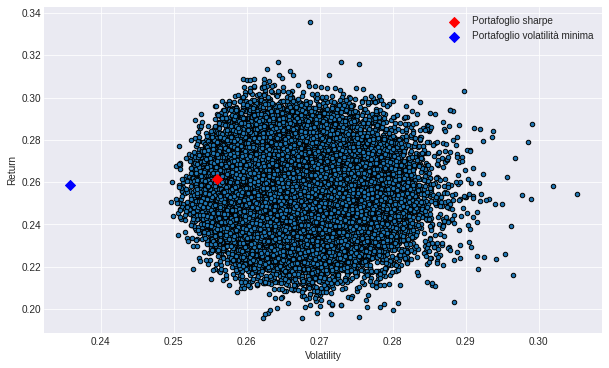

In [311]:
#plottiamo i dati delle combinazioni di portafoglio 
portfoglios=pd.DataFrame({'Return': pfoglio_returns2, 'Volatility': pfoglio_volatilities2})
plt.style.use('seaborn-dark')
portfoglios.plot( x='Volatility', y='Return', kind='scatter',figsize=(10,6),edgecolors='black',
                  grid=True);
plt.scatter(x=rit_sharpe, y= vol_sharpe, 
            c='red', marker='D', s=50 , label = 'Portafoglio sharpe');
plt.scatter(x= rit_min, y= vol_min, 
            c='blue', marker='D', s=50, label = 'Portafoglio volatilità minima');
plt.legend();


